In [1]:
! pip install --upgrade ..  > /dev/null

In [2]:
!tree -h ../data/design_matrix/sample_3_8_50

../data/design_matrix/sample_3_8_50
├── [   0]  _SUCCESS
└── [137M]  part-00000-46bae0ef-579a-448e-8a6d-34b128eef082-c000.snappy.parquet

0 directories, 2 files


In [3]:
!ls ../data/design_matrix

sample_10_8_50 sample_2_8_50  sample_4_8_50  sample_6_8_50  sample_8_8_50
sample_1_8_50  sample_3_8_50  sample_5_8_50  sample_7_8_50  sample_9_8_50


In [6]:
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


N_CUTS = 8
START_DATE = datetime.strptime("2018-01-01", "%Y-%m-%d")
END_DATE = datetime.strptime("2019-09-01", "%Y-%m-%d")

META = ["partition_id", "title"]
DEGREE = ["degree", "inDegree", "outDegree"]
SIGN = [f"sign_{i}" for i in range(N_CUTS)]
VECTOR = [f"fiedler_{i}" for i in range(N_CUTS)]
DATES = [(START_DATE + timedelta(t)).strftime("%Y-%m-%d")
         for t in range((END_DATE-START_DATE).days)]

SCHEMA = META + DEGREE + SIGN + VECTOR + DATES


data = pd.read_parquet(glob.glob("../data/design_matrix/sample_6_8_50/*.parquet")[0])
pretty_columns = META+DEGREE+SIGN[:1]+VECTOR[:1]+DATES[:3]
print(data.shape)
data.loc[:, pretty_columns].sample(5)

(302348, 630)


,partition_id,title,degree,inDegree,outDegree,sign_0,fiedler_0,2018-01-01,2018-01-02,2018-01-03
141786,xoxoxxxx,1932_Cincinnati_Reds_season,89.0,42.0,47.0,True,1.606870e-10,NaN,NaN,NaN
296321,xxoooxxx,Virginian_Golf_Club,63.0,24.0,39.0,True,2.127291e-11,NaN,NaN,NaN
84380,oxooxooo,Meitetsu_Nagoya_Main_Line,37.0,6.0,31.0,False,-1.831993e-06,NaN,NaN,NaN
239512,ooxxooxx,Stagmatoptera_nova,97.0,31.0,66.0,False,-6.104415e-10,NaN,NaN,NaN
46433,oooxxooo,Massimo_Girotti,146.0,73.0,73.0,False,-5.959446e-11,NaN,NaN,NaN


# Check memory usage and missing elements

In [8]:
def print_memory(row_bytes, num_rows, label=None):
    buffer = f"{row_bytes/num_rows} bytes per row, {row_bytes/1e6} MB total"
    if label:
        buffer += f", {label}"
    print(buffer)

memory_usage = data.memory_usage()
print_memory(memory_usage.sum(), data.shape[0])

memory = lambda f, label: print_memory(memory_usage[f].sum(), data.shape[0], label)
memory(META, "metadata for query optimization")
memory(DEGREE+SIGN+VECTOR, "graph features")
memory(DATES, "page views")
data.groupby("partition_id").count().loc[:, pretty_columns[1:]].head

5011.000423353222 bytes per row, 1515.065956 MB total
16.0 bytes per row, 4.837568 MB total, metadata for query optimization
131.0 bytes per row, 39.607588 MB total, graph features
4860.0 bytes per row, 1469.41128 MB total, page views


# Model training

(50000, 84) (50000, 7) (50000, 7)


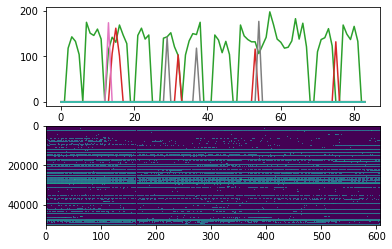

In [138]:
from sklearn.preprocessing import StandardScaler

sample_size = 5*10**4
sample = data.fillna(0.0).sample(sample_size)
train, validate, test = create_dataset(sample[DATES], 7, 14, standardize=False)
print(train.shape, validate.shape, test.shape)

plt.subplots()

plt.subplot(211)
x = np.arange(train.shape[1])
for i in range(10):
    plt.plot(x, train[i])

plt.subplot(212)
plt.imshow(np.log(sample.sort_values(by=["sign_0", "inDegree"])[DATES].values+1), aspect="auto")
plt.show()

In [146]:
from functools import partial
import itertools
import warnings
import numpy as np

import scipy.stats as stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor

#from wikicast.data import create_dataset
from wikicast.baseline import summarize
from wikicast.data import rmse, mape


warnings.filterwarnings("ignore")


def display_columns(df):
    return df[[
        x for x in df.columns.tolist()
        if x.startswith("rank") or x.startswith("param_") 
        or x.startswith("mean") or x.startswith("std")
    ]]


def train_best_model(model, param_distributions, scoring={}, train=train, features=[graph], refit="rmse", **kwargs):
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        scoring=scoring or {
            "rmse": make_scorer(rmse, greater_is_better=False),
            "mape": make_scorer(mape, greater_is_better=False),
        },
        refit=refit,
        cv=3,
        **kwargs,
    )
    # these are globals at the moment
    result = run_trial("neural network", search, train, validate, test, features)
    print(result)
    records = pd.DataFrame(search.cv_results_).sort_values(f"rank_test_rmse")
    return records


def ablation(search, sample):
    scaler = StandardScaler()
    res = []
    features = [("degree", sample[DEGREE]), ("sign", sample[SIGN]), ("vector", sample[VECTOR])]
    for pair in itertools.combinations(features, 2):
        name, feat = zip(*pair)
        names = " + ".join(name)
        feat = [scaler.fit_transform(f) for f in feat]
        res += run_trial(f"neural network ({names})", search, train, validate, test, feat)
        print(pd.DataFrame(grid_nn.cv_results_).sort_values("rank_test_neg_mean_squared_error").loc[0, ["params"]])
    return pd.DataFrame(res)


# assume the timeseries are a numpy array
def create_dataset(ts, window_size=7, n_panes=14, standardize=True, denoise=False):
    X = ts.fillna(0.0).values
    T = X.shape[1]
    window_size = 7

    indexer = np.arange(window_size).reshape(1, -1) + window_size * np.arange(
        T // window_size
    ).reshape(-1, 1)

    panes = X[:, indexer]
        
    train = panes[:, : n_panes - 2, :]
    
    train = train.reshape(panes.shape[0], -1)
    if standardize:
        train -= train.mean(axis=1)[:, np.newaxis]
        train = np.ma.divide(train, train.std(axis=1)[:, np.newaxis]).filled(0)

    validate = panes[:, n_panes - 1, :]
    test = panes[:, n_panes, :]
    return train, validate, test


def run_trial(name, model, train, validate, test, features=[], feature_labels=[], **kwargs):
    test_X = np.hstack([train[:, 7:], validate])

    results = []
    z = np.hstack([train]+features)
    model.fit(z, validate, **kwargs)
    z = np.hstack([test_X]+features)
    results.append(summarize(name, test, model.predict(z)))
    return results

## graph feature scaling

In [147]:
scaler = StandardScaler()
z = sample[DEGREE+SIGN+VECTOR].fillna(0)
graph = scaler.fit_transform(z)

## Linear Regresion

In [148]:
res = []
train_std, _, _ = create_dataset(sample[DATES], 7, 14, standardize=True)
res += run_trial("linear regression with standard", LinearRegression(), train_std, validate, test)
res += run_trial("linear regression AR(7)", LinearRegression(), train[:, -7:], validate, test)
res += run_trial("linear regression AR(7*12)", LinearRegression(), train, validate, test)
res += run_trial("linear regression with graph", LinearRegression(), train, validate, test, [z])
res += run_trial("linear regression with graph standard", LinearRegression(), train, validate, test, [graph])
res += run_trial("linear regression with graph only", LinearRegression(), graph, validate, test)
pd.DataFrame(res)

,mape,rmse,name
0,1.015983e+16,1.987033e+17,linear regression with standard
1,7.933555e+01,4.851223e+02,linear regression AR(7)
2,7.737290e+01,4.239445e+02,linear regression AR(7*12)
3,7.739310e+01,4.241088e+02,linear regression with graph
4,7.738386e+01,4.237490e+02,linear regression with graph standard
5,1.764115e+02,2.294794e+03,linear regression with graph only


### Ridge

In [135]:
scoring = {
    "rmse": make_scorer(rmse, greater_is_better=False),
    "mape": make_scorer(mape, greater_is_better=False),
}
grid_ridge = GridSearchCV(
    estimator=Ridge(),
    param_grid={
        "alpha": [1e-3, 0, 1, 1e5, 1e8, 1e9, 1e10, 1e11, 1e12]
    },
    scoring=scoring,
    refit="rmse",
    cv=3,
    n_jobs=-1,
)

%time print(run_trial("ridge regression", grid_ridge, train, validate, test, [graph]))
display_columns(pd.DataFrame(grid_ridge.cv_results_))

[{'mape': 76.0870404822372, 'rmse': 462.18741821151804, 'name': 'ridge regression'}]
CPU times: user 298 ms, sys: 338 ms, total: 635 ms
Wall time: 1.56 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_test_mape,std_test_mape,rank_test_mape
0,0.339246,0.031660,0.036250,0.006909,0.001,-760.568110,561.782131,8,-78.304034,2.236194,8
1,0.660855,0.510667,0.033282,0.017655,0,-794.512255,609.800777,9,-78.412651,2.385834,9
2,0.397577,0.040471,0.029933,0.000818,1,-601.969125,337.685077,5,-77.431762,1.055314,6
3,0.430338,0.002849,0.035711,0.000675,100000,-599.525459,335.677332,3,-77.232441,1.090899,5
4,0.374260,0.011277,0.041181,0.005016,1e+08,-592.295431,327.752480,2,-76.889127,0.979306,4
5,0.408164,0.012744,0.036422,0.001305,1e+09,-585.849179,310.164985,1,-76.260394,0.741226,3
6,0.387264,0.025367,0.037440,0.006071,1e+10,-599.918386,287.255287,4,-75.898847,0.615732,2
7,0.328352,0.050281,0.033483,0.009018,1e+11,-628.533695,263.018992,6,-75.849953,0.262662,1
8,0.249084,0.005409,0.019360,0.001732,1e+12,-686.986687,259.125998,7,-77.784469,1.376320,7


In [151]:
features = [sample[DEGREE+SIGN+VECTOR]]
%time display_columns(train_best_model(Ridge(), {"alpha": stats.reciprocal(a=1e-2, b=1e11)}, features=features, n_iter=100))

[{'mape': 76.33478700791737, 'rmse': 392.08889075016816, 'name': 'neural network'}]
CPU times: user 8min, sys: 1min 26s, total: 9min 26s
Wall time: 2min 17s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_test_mape,std_test_mape,rank_test_mape
25,0.329599,0.005979,0.100301,0.002541,1.36186e+09,-353.911146,58.767078,1,-76.329736,0.701250,13
71,0.326482,0.004109,0.098648,0.000621,1.33763e+09,-353.949303,58.348853,2,-76.332996,0.701050,14
22,0.330359,0.008237,0.104266,0.002376,1.25453e+09,-354.112088,56.853430,3,-76.344918,0.700283,15
59,0.325776,0.000824,0.099635,0.001093,1.1232e+09,-354.487242,54.281668,4,-76.366308,0.699454,16
0,0.333051,0.019442,0.098095,0.000742,2.67384e+09,-354.979714,73.724780,5,-76.232667,0.697778,12
...,...,...,...,...,...,...,...,...,...,...,...
93,0.332541,0.003569,0.105947,0.004886,0.0232383,-401.459005,44.858882,96,-77.228479,0.722758,96
3,0.327885,0.003929,0.096809,0.000345,0.0201485,-401.459042,44.858929,97,-77.228481,0.722761,97
86,0.328537,0.001363,0.098573,0.001814,0.0175727,-401.459083,44.858984,98,-77.228483,0.722765,98
96,0.331479,0.002227,0.101576,0.000848,0.0117379,-401.459240,44.859209,99,-77.228487,0.722776,99


In [136]:
%time display_columns(train_best_model(Ridge(), {"alpha": stats.reciprocal(a=1e-2, b=1e11)}, features=[graph], n_iter=100))

[{'mape': 76.14631574940802, 'rmse': 468.2264360371896, 'name': 'neural network'}]
CPU times: user 3min 40s, sys: 47.6 s, total: 4min 28s
Wall time: 25 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_test_mape,std_test_mape,rank_test_mape
42,0.068910,0.000422,0.009742,0.000433,7.7747e+08,-585.669851,312.555024,1,-76.325307,0.769824,15
22,0.065061,0.001156,0.008626,0.000195,8.71592e+08,-585.712443,311.481109,2,-76.295388,0.756898,14
71,0.070788,0.000749,0.009017,0.000283,5.57745e+08,-585.899366,315.559672,3,-76.416602,0.806984,16
54,0.070719,0.000688,0.009992,0.000440,5.31431e+08,-585.974367,315.981431,4,-76.430304,0.812387,17
29,0.064468,0.000700,0.009412,0.000591,1.19974e+09,-586.175425,308.383896,5,-76.215710,0.721044,13
...,...,...,...,...,...,...,...,...,...,...,...
82,0.073384,0.000239,0.010634,0.000685,3.10081e+10,-611.363251,276.536855,96,-75.831495,0.533197,4
49,0.069410,0.001499,0.010266,0.000749,5.30061e+10,-618.198009,270.570278,97,-75.816491,0.372650,1
38,0.068972,0.001388,0.009500,0.000910,7.84016e+10,-624.246616,265.879597,98,-75.826893,0.250382,2
21,0.066436,0.002429,0.009429,0.000198,7.85055e+10,-624.268826,265.863716,99,-75.826980,0.250163,3


In [149]:
%time display_columns(train_best_model(Ridge(), {"alpha": stats.reciprocal(a=1e-6, b=1e11)}, features=[], n_iter=100))

[{'mape': 76.0038741982324, 'rmse': 378.46760110136853, 'name': 'neural network'}]
CPU times: user 2min 56s, sys: 50.4 s, total: 3min 47s
Wall time: 21.6 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_test_mape,std_test_mape,rank_test_mape
52,0.057754,0.000811,0.009196,0.000809,3.20996e+09,-356.045079,77.148292,1,-76.220756,0.689089,15
20,0.055560,0.000080,0.009860,0.000925,3.53559e+09,-356.745787,78.936690,2,-76.210726,0.686934,14
37,0.062808,0.001350,0.011749,0.001033,7.5181e+08,-356.856920,45.387800,3,-76.450341,0.698233,16
63,0.056800,0.001701,0.009070,0.000374,5.0998e+09,-359.961868,85.194262,4,-76.172432,0.680614,13
61,0.059962,0.001490,0.009256,0.001235,4.41367e+08,-361.892281,35.689289,5,-76.576802,0.694254,17
...,...,...,...,...,...,...,...,...,...,...,...
44,0.057991,0.000821,0.009522,0.001628,0.0465872,-400.829662,43.787246,96,-77.194550,0.726051,96
85,0.057086,0.000702,0.008793,0.000372,0.0286289,-400.829662,43.787246,97,-77.194550,0.726051,97
56,0.057354,0.001306,0.010272,0.001723,0.0265373,-400.829662,43.787246,98,-77.194550,0.726051,98
16,0.051727,0.000414,0.008888,0.001572,0.0177646,-400.829662,43.787246,99,-77.194550,0.726051,99


## Neural Network

In [104]:
print(train.shape)
%time res = train_best_nn([(8,)], n_iter=1)
display_columns(res)

(50000, 84)
[{'mape': 82.61760562407152, 'rmse': 523.5934978165476, 'name': 'neural network'}]
CPU times: user 4min 36s, sys: 43.2 s, total: 5min 19s
Wall time: 54.5 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate_init,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_test_mape,std_test_mape,rank_test_mape
0,12.042574,0.536398,0.009835,0.000351,relu,0.00455009,"(8,)",4.68799e-06,-1187.755539,492.364823,1,-91.030491,0.421094,1


### Trials
Run each trial, a layer at a time. We first figure out what the best range for learning rates should be by fixing the size of the best model.

In [195]:
def train_best_nn(layers, params={}, **kwargs):
    return train_best_model(
        MLPRegressor(solver="adam", early_stopping=True),
        {**{
            "learning_rate_init": stats.reciprocal(a=1e-6, b=1e-4),
            "activation": ["relu"],
            "alpha": stats.reciprocal(a=1e-6, b=1e6),
            "hidden_layer_sizes": layers
        }, **params},
        **kwargs
    )

def run_search_nn(layers, trial_id, n_iter):
    n_layer = len(layers[0])
    res = train_best_nn(layers, n_iter=n_iter)
    name = f"nn_{trial_id}_{n_layer}_{n_iter}"
    print(name)
    res.to_csv(f"{name}.csv")
    return res

trial_id = 1
sizes = [8, 16, 32, 64, 128]

In [107]:
layers = list(itertools.product(sizes, repeat=1)) 
%time res = run_search_nn(layers, trial_id, 100)
display_columns(res)

[{'mape': 76.48199727609149, 'rmse': 359.2639026222402, 'name': 'neural network'}]
nn_1_1_100
CPU times: user 7h 5min 55s, sys: 1h 6min 43s, total: 8h 12min 39s
Wall time: 1h 23min 49s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate_init,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_test_mape,std_test_mape,rank_test_mape
4,16.174571,0.169497,0.021268,0.000444,relu,693547,"(32,)",5.28078e-05,-837.115767,726.268045,1,-76.963173,0.156225,1
39,12.243773,0.058576,0.009693,0.000353,relu,3.07958e-06,"(8,)",4.5685e-05,-846.061742,720.848041,2,-77.170574,0.196255,3
91,10.775708,2.212038,0.009717,0.000517,relu,0.000453242,"(8,)",7.05484e-05,-848.826612,718.926478,3,-77.402331,0.436073,6
99,30.193703,2.830428,0.044260,0.000699,relu,7.86033,"(128,)",1.85389e-05,-854.263039,713.683671,4,-77.677350,0.283764,11
44,14.074111,0.027879,0.016905,0.000181,relu,560594,"(16,)",4.1294e-05,-857.022389,713.296951,5,-77.308649,0.667456,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,9.389312,4.682838,0.010229,0.000984,relu,436.606,"(8,)",6.96948e-06,-1229.189396,513.532481,96,-92.152101,1.594786,87
64,12.408835,6.156515,0.022291,0.001084,relu,0.00326245,"(32,)",3.88816e-06,-1244.137800,457.389896,97,-84.326129,2.985248,74
37,8.425111,5.397994,0.010281,0.001230,relu,0.00310914,"(8,)",1.55262e-06,-1256.793390,520.504783,98,-102.003901,0.794207,100
47,14.538171,0.366319,0.015452,0.002142,relu,0.0760267,"(16,)",2.79161e-06,-1260.488419,449.060011,99,-85.371799,1.329053,79


In [143]:
params = {
    "learning_rate_init": [5.28078e-05],
    "activation": ["relu"],
    "alpha": stats.reciprocal(1e4, 1e8),
    "hidden_layer_sizes": [(32,)]
}
%time x = train_best_model(MLPRegressor(solver="adam", early_stopping=True), params)

[{'mape': 76.14600075646301, 'rmse': 381.77165123172495, 'name': 'neural network'}]
CPU times: user 36min 29s, sys: 5min 36s, total: 42min 6s
Wall time: 7min 9s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate_init,params,split0_test_rmse,...,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mape,split1_test_mape,split2_test_mape,mean_test_mape,std_test_mape,rank_test_mape
3,9.418575,2.808929,0.021350,0.001160,relu,1.08543e+07,"(32,)",5.28078e-05,"{'activation': 'relu', 'alpha': 10854279.11426...",-330.924334,...,-469.121556,-359.360606,80.557198,1,-78.306809,-77.122422,-75.591510,-77.006942,1.111514,3
8,16.893496,0.363329,0.024205,0.002764,relu,1.58178e+06,"(32,)",5.28078e-05,"{'activation': 'relu', 'alpha': 1581779.678990...",-282.653136,...,-482.156459,-365.268355,84.974245,2,-76.647424,-77.760760,-75.825031,-76.744423,0.793225,2
9,15.358727,2.412925,0.023551,0.001498,relu,211067,"(32,)",5.28078e-05,"{'activation': 'relu', 'alpha': 211066.5096287...",-315.158029,...,-450.287165,-372.506638,57.025661,3,-77.027152,-78.750977,-77.177090,-77.651749,0.779690,10
5,16.966113,0.123902,0.024318,0.000857,relu,94358.6,"(32,)",5.28078e-05,"{'activation': 'relu', 'alpha': 94358.62287350...",-280.131019,...,-450.576048,-372.839552,70.384826,4,-77.337974,-78.368087,-76.727761,-77.477956,0.676933,6
1,15.094226,0.891231,0.025277,0.002663,relu,6.67447e+06,"(32,)",5.28078e-05,"{'activation': 'relu', 'alpha': 6674468.230539...",-327.666954,...,-488.612466,-376.199727,79.731770,5,-77.062386,-77.275227,-75.400410,-76.579365,0.838138,1
4,6.065760,0.588549,0.023336,0.001170,relu,7.12762e+07,"(32,)",5.28078e-05,"{'activation': 'relu', 'alpha': 71276187.89611...",-331.958077,...,-545.431218,-385.372527,115.241911,6,-77.125211,-77.375068,-76.742797,-77.081032,0.260006,4
7,16.782369,0.155248,0.022811,0.000572,relu,11431.9,"(32,)",5.28078e-05,"{'activation': 'relu', 'alpha': 11431.94739991...",-302.726492,...,-482.965713,-386.349383,74.152886,7,-77.552089,-78.134226,-76.642711,-77.443025,0.613770,5
0,16.090458,0.703909,0.022971,0.000929,relu,104602,"(32,)",5.28078e-05,"{'activation': 'relu', 'alpha': 104601.8617022...",-317.129050,...,-477.297206,-398.171088,65.402152,8,-77.398293,-78.123269,-77.004119,-77.508570,0.463496,7
6,7.742346,2.004208,0.022474,0.001782,relu,8.36752e+07,"(32,)",5.28078e-05,"{'activation': 'relu', 'alpha': 83675166.70372...",-365.965381,...,-533.083668,-399.964124,97.808636,9,-77.972111,-78.222963,-76.341673,-77.512273,0.834026,8
2,17.425992,0.618398,0.023912,0.001107,relu,199225,"(32,)",5.28078e-05,"{'activation': 'relu', 'alpha': 199225.1717029...",-558.525605,...,-451.097417,-441.998269,99.068789,10,-77.818103,-78.387649,-76.496273,-77.567363,0.792242,9


In [163]:
layers = list(itertools.product(sizes, repeat=2))
params = {
    "learning_rate_init": [5.28078e-05],
    "activation": ["relu"],
    "alpha": [1.08543e+07],
    "hidden_layer_sizes": layers
}
grid = GridSearchCV(
    estimator=MLPRegressor(solver="adam", early_stopping=True),
    param_grid=params,
    scoring=scoring,
    refit="rmse",
    cv=3,
    n_jobs=-1,

)

%time print(run_trial("neural net", grid, train, validate, test, [graph]))
display_columns(pd.DataFrame(grid.cv_results_)).sort_values("rank_test_rmse")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate_init,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_test_mape,std_test_mape,rank_test_mape
6,45.876463,7.879963,0.054675,0.010999,relu,1.08543e+07,"(16, 16)",5.28078e-05,-347.980918,108.797261,1,-76.389658,0.563916,3
21,57.263337,3.209254,0.108488,0.004411,relu,1.08543e+07,"(128, 16)",5.28078e-05,-349.884908,116.531463,2,-76.135646,0.609817,1
19,68.143081,17.609838,0.137397,0.000414,relu,1.08543e+07,"(64, 128)",5.28078e-05,-352.057112,111.449714,3,-76.406467,1.026757,4
2,12.252557,1.876150,0.066684,0.014036,relu,1.08543e+07,"(8, 32)",5.28078e-05,-355.506812,115.129050,4,-76.593308,0.557862,7
1,29.452723,5.338490,0.097648,0.053500,relu,1.08543e+07,"(8, 16)",5.28078e-05,-356.662163,107.501501,5,-76.321461,0.795350,2
15,46.500245,11.135013,0.070813,0.007884,relu,1.08543e+07,"(64, 8)",5.28078e-05,-361.508514,106.568310,6,-76.923660,0.932328,23
23,40.476201,13.682110,0.121147,0.028902,relu,1.08543e+07,"(128, 64)",5.28078e-05,-361.651622,87.600989,7,-76.743762,1.040981,20
10,66.312945,13.548171,0.060326,0.005153,relu,1.08543e+07,"(32, 8)",5.28078e-05,-363.699994,84.885361,8,-76.792263,0.979638,21
3,15.194622,1.750118,0.080535,0.009561,relu,1.08543e+07,"(8, 64)",5.28078e-05,-364.420243,105.349188,9,-76.703413,0.880338,17
17,81.718447,45.276750,0.102990,0.015081,relu,1.08543e+07,"(64, 32)",5.28078e-05,-364.468744,86.808917,10,-76.652852,0.726189,10


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

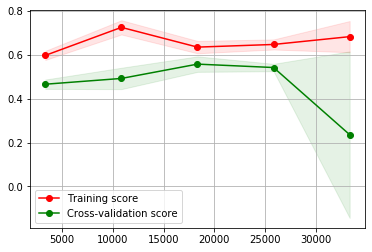

In [186]:
from sklearn.model_selection import learning_curve

%time train_sizes, train_scores, test_scores = learning_curve(
    grid.best_estimator_, np.hstack([train, graph]), validate
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.plot

In [193]:
pd.DataFrame(grid.cv_results_).sort_values("rank_test_rmse")["param_hidden_layer_sizes"][:5].tolist()

[(16, 16), (128, 16), (64, 128), (8, 32), (8, 16)]

In [198]:
layers = pd.DataFrame(grid.cv_results_).sort_values("rank_test_rmse")["param_hidden_layer_sizes"][:5].tolist()
params = {
    "learning_rate_init": stats.reciprocal(a=1e-6, b=1e-4),
    "activation": ["relu"],
    "alpha":  stats.reciprocal(a=1e6, b=1e8),
    "hidden_layer_sizes": layers
}
%time res = train_best_model(MLPRegressor(solver="adam", early_stopping=True), params, n_iter=100)
res.to_csv(f"nn_{trial_id}_2_100_best_5.csv")
display_columns(res)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate_init,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_test_mape,std_test_mape,rank_test_mape
63,28.058152,5.506274,0.057393,0.001087,relu,4.35849e+06,"(64, 128)",2.72422e-05,-342.818223,104.905872,1,-76.120440,0.498195,1
97,26.481858,10.977055,0.060863,0.003250,relu,5.41052e+06,"(64, 128)",1.99133e-05,-343.801424,93.219529,2,-76.218343,0.600524,3
66,15.758181,1.487553,0.014638,0.000398,relu,1.12756e+06,"(8, 16)",6.03467e-05,-344.722706,90.152631,3,-76.927154,0.911305,21
73,26.396985,5.517019,0.048170,0.000281,relu,2.75734e+06,"(128, 16)",2.47808e-05,-345.552954,92.221525,4,-76.212391,0.606669,2
46,12.766167,4.749674,0.048330,0.000045,relu,7.49652e+06,"(128, 16)",6.15635e-05,-350.520203,94.136033,5,-76.400892,0.566797,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,18.652091,0.061459,0.017174,0.000218,relu,3.73251e+07,"(8, 32)",1.3301e-06,-582.521156,102.047805,96,-94.817599,5.057363,91
24,18.880989,0.029803,0.017072,0.000798,relu,1.25632e+07,"(16, 16)",2.63756e-06,-585.219869,155.847728,97,-98.025645,1.723846,99
81,12.334198,6.564729,0.014459,0.000419,relu,6.34698e+07,"(8, 16)",1.01541e-06,-591.996912,168.722731,98,-101.280137,0.625207,100
29,15.548526,4.465012,0.016889,0.000349,relu,1.44531e+07,"(8, 32)",1.33387e-06,-598.252089,81.488649,99,-95.452368,4.938837,93


In [ ]:
# layers = list(itertools.product(sizes[:4], repeat=2)) 
# %time run_search_nn(layers, trial_id, 100)
# [{'mape': 77.01096281747452, 'rmse': 749.688293322429, 'name': 'neural network'}]
# -339.242129, -78.021344

### all layers of 3

In [ ]:
layers = list(itertools.product(sizes, repeat=3)) 
%time run_search_nn(layers, trial_id, 250)

In [ ]:
layers = list(itertools.product(sizes, repeat=4)) 
%time run_search_nn(layers, trial_id, 250)